In [5663]:
# Copyright [2025] [KTH Royal Institute of Technology] 
# Licensed under the Educational Community License, Version 2.0 (ECL-2.0)
# This file is part of the Computer Lab 1 for EL2805 - Reinforcement Learning.

# Load packages
import numpy as np
import gymnasium as gym
import torch
import matplotlib.pyplot as plt
import pickle

# Import and initialize Mountain Car Environment
env = gym.make('MountainCar-v0')
env.reset()
k = env.action_space.n      # tells you the number of actions
low, high = env.observation_space.low, env.observation_space.high

In [5664]:
class Model:

    def __init__(self, eta, lam, gamma, mu):
        self.eta = eta #(m,2)
        self.m = eta.shape[0]
        self.weights = self.__init_weights(self.m) #(m,3)
        self.z = np.zeros((self.m,3))
        self.lam = lam
        self.gamma = gamma
        self.v = np.zeros((self.m,3))
        self.mu = mu

        eta_norm = np.linalg.norm(self.eta, axis=1)
        self.inv_eta_norm = np.diag(1/np.where(eta_norm > 0, eta_norm, 1)) # (m,m) diag
        

    def forward(self, s):
        return self.weights.T @ np.cos(np.pi*self.eta @ s) # (3,)

    def __init_weights(self, m):
        return np.zeros((m,3))
    
    def eps_greedy(self, s, eps):
        if np.random.rand() < 1-eps:
            return np.argmax(self.forward(s))
        else:
            return np.random.randint(3)

    def update_trace(self, s, a):
        self.z *= self.gamma*self.lam
        self.z[:, a] += np.cos(np.pi*self.eta @ s)
        self.z = np.clip(self.z, -5, 5)

    def Phi(self, s):
        return np.cos(np.pi*self.eta @ s)

    def Q(self,s,a):
        return (self.weights.T @ self.Phi(s))[a]

    def update_weights(self, s, a, r, s_next, a_next, alpha):
        delta = (r+self.gamma*self.Q(s_next, a_next)-self.Q(s,a))
        self.weights +=  alpha*delta*(self.inv_eta_norm @ self.z)

    def update_weights_momentum(self, s, a, r, s_next, a_next, alpha):
        delta = (r+self.gamma*self.Q(s_next, a_next)-self.Q(s,a))
        self.v = self.mu * self.v + alpha*delta*(self.inv_eta_norm @ self.z)
        self.weights += self.v
    
    def update_weights_nesterov(self, s, a, r, s_next, a_next, alpha):
        delta = (r+self.gamma*self.Q(s_next, a_next)-self.Q(s,a))
        self.v = self.mu * self.v + alpha*delta*(self.inv_eta_norm @ self.z)
        self.weights += self.mu * self.v + alpha*delta*(self.inv_eta_norm @ self.z)
    

    def reset_trace(self):
        self.z = np.zeros((self.m,3))
        self.v = np.zeros((self.m,3))

    def save(self, file_name):
        d = {}
        d["N"] = self.eta
        d["W"] = self.weights.T

        with open(file_name, 'wb') as file:
            pickle.dump(d, file)

In [5665]:

# Functions used during training
def running_average(x, N):
    ''' Function used to compute the running mean
        of the last N elements of a vector x
    '''
    if len(x) >= N:
        y = np.copy(x)
        y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
    else:
        y = np.zeros_like(x)
    return y

def scale_state_variables(s, low=env.observation_space.low, high=env.observation_space.high):
    ''' Rescaling of s to the box [0,1]^2 '''
    x = (s - low) / (high - low)
    return x


In [5666]:
# ----- good combos
# np.array([[1,1], [2, 2], [1, 2], [2, 1], [0, 1]])
# -----

# np.array([[0,1], [0,2], [1, 0], [2, 0]])
# np.array([[0, 1], [0,0], [0, 2]])#random.np.array([(i,j) for i in range(3) for j in range(3)])
# np.array([(i,j) for i in range(3) for j in range(3)])
# np.array([[0, 1], [0, 2], [1, 1], [2,2]]) #np.array([(i,j) for i in range(3) for j in range(3)]) # (m,2)

eta = np.array([[1,1], [2, 2], [1, 2], [2, 1], [0, 1]])
lam = 0.8 # for eligibility trace
gamma = 1.0 # discount factor
N_episodes = 200 # Number of episodes to run for training
EPS = 0.05 # base exploration rate
ALPHA = 0.003 # base learning rate

lr_lookback = 5 # learning rate reduction lookback
lr_threshold = -160 # threshold for learning rate reduction
# factor to multiply lr with if mean over last look_back episode rewards is less than lr_threshold:
lr_factor = 0.1

mu = 0.5 # SGD momentum/nesterov factor

In [5667]:
params = {
    "eta": tuple(tuple(int(x) for x in row) for row in eta),
    "lam": lam,
    "gamma": gamma,
    "N_episodes": N_episodes,
    "EPS": EPS,
    "ALPHA": ALPHA,
    "lr_lookback": lr_lookback,
    "lr_threshold": lr_threshold,
    "lr_factor": lr_factor,
    "mu": mu
}

In [5668]:
model = Model(eta, lam, gamma, mu) 
episode_reward_list = []
last_epsiode_pos = []
last_epsidoe_vel = []

visited_states = [[] for _ in range(3)]

# Training process
for i in range(N_episodes):
    # Reset enviroment data
    done = False
    truncated = False
    state = scale_state_variables(env.reset()[0])
    total_episode_reward = 0.

    eps = EPS

    alpha = ALPHA
    if i > lr_lookback and lr_threshold < np.mean(episode_reward_list[-lr_lookback:]):
        alpha *= lr_factor

    model.reset_trace()
    action =  model.eps_greedy(state, eps)

    while not (done or truncated):
        if i == N_episodes-1:
            last_epsiode_pos.append(state[0])
            last_epsidoe_vel.append(state[1])

        # Take a random action
        # env.action_space.n tells you the number of actions
        # available
        
        # Get next state and reward.  The done variable
        # will be True if you reached the goal position,
        # False otherwise. Truncated is true if you reach 
        # the maximal number of time steps, False else.

        next_state, reward, done, truncated, _ = env.step(action)
        next_state = scale_state_variables(next_state)

        next_action = model.eps_greedy(next_state, eps)

        model.update_trace(state, action)
        model.update_weights_momentum(state, action, reward, next_state, next_action, alpha)
        
        # Update episode reward
        total_episode_reward += reward

        # Update visited_states
        visited_states[action].append(state)
        
        # Update state for next iteration
        state = next_state
        action = next_action

    # Append episode reward
    episode_reward_list.append(total_episode_reward)

    # Close environment
    env.close()
    

In [5669]:
# UCB
# 1/(2*len(visited_states[0])) * np.sum(np.exp(-(np.array((0.5,0.5)) - visited_states[0])/2))

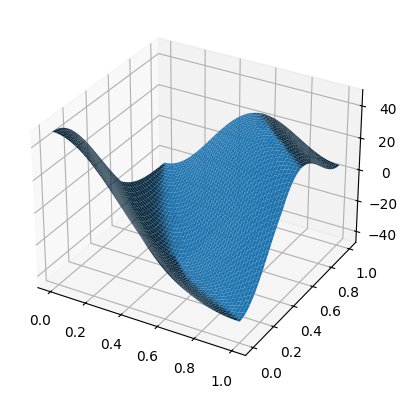

In [5670]:
N = 500
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y)

# Compute Q-values over the grid and take max over actions
pts = np.vstack([X.ravel(), Y.ravel()])  # shape (2, N*N)
Phi_all = np.cos(np.pi * (model.eta @ pts))  # (m, N*N)
Q_all = model.weights.T @ Phi_all  # (3, N*N)
Z = np.max(Q_all, axis=0).reshape(X.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)


# N = 500
# x = np.linspace(0, 1, N)
# y = np.linspace(0, 1, N)
# X, Y = np.meshgrid(x, y)

# # Compute Q-values over the grid and take max over actions
# pts =np.stack([X, Y], axis=-1)  
# np.max((np.cos(np.pi*pts @ model.eta.T) @ model.weights), axis=-1)

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(X, Y, Z)

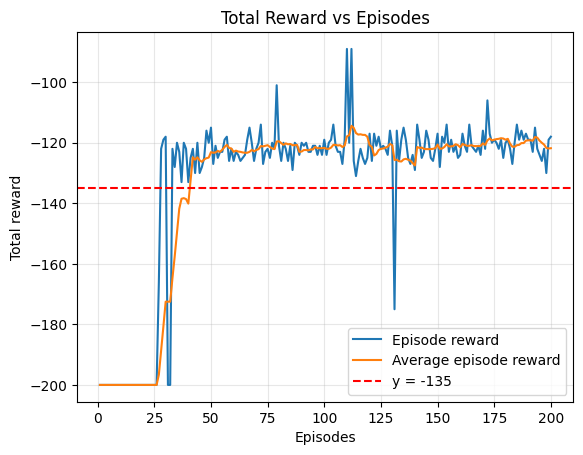

In [5671]:
# Plot Rewards
plt.plot([i for i in range(1, N_episodes+1)], episode_reward_list, label='Episode reward')
plt.plot([i for i in range(1, N_episodes+1)], running_average(episode_reward_list, 10), label='Average episode reward')
plt.xlabel('Episodes')
plt.ylabel('Total reward')
plt.axhline(-135, color='r', linestyle='--', label='y = -135')
plt.title('Total Reward vs Episodes')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [5672]:
model.save("weights.pkl")

In [5673]:
model.weights

array([[29.70365638, 30.49035118, 29.43310569],
       [-6.58074114, -7.22845903, -7.22178537],
       [11.13693147, 11.25352368, 14.37946446],
       [12.08235297, 13.82328671,  9.02667519],
       [ 1.69969019, -0.81593409, -5.96778637]])